# **CSCI 4980: Homework 3** <br>
## **Noah Hendrickson** <br>

<br>

----------------------

## **Imports and Data Loading/Normalization**

In [1]:
import numpy as np
import pandas as pd
import torch, torchvision
from torch import nn
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
data = pd.read_csv("data.csv")
data.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6


split data and labels

In [3]:
y_df = data.iloc[:,-1].copy()
X_df = data.iloc[:,:-1].copy()

In [4]:
X_df_not_normal = X_df.copy()
X_df = (X_df - X_df.mean()) / X_df.std()

convert dataframe to tensor

In [5]:
X_tens = torch.tensor(X_df.values).float()
y_tens = torch.tensor(y_df.values).float()

X_tens_not_normal = torch.tensor(X_df_not_normal.values).float()

also convert dataframe to numpy

In [6]:
X_np = X_df.to_numpy()
y_np = y_df.to_numpy()

-------------------------

# **Problem 1: Visualizing Data**

## Part A: Histogram of Counts

[6, 5, 7, 8, 4, 3, 9]


<Axes: xlabel='quality', ylabel='count'>

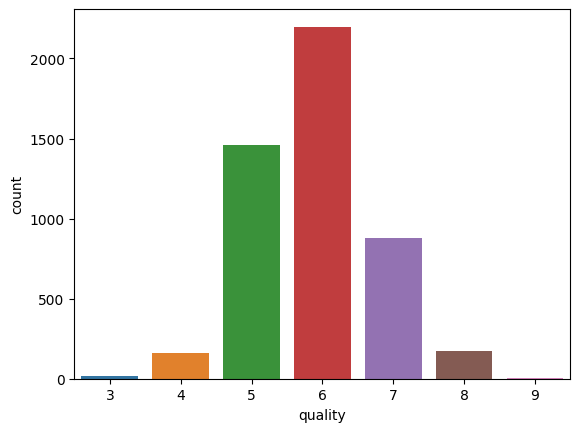

In [7]:
unique_vals = []
for i,val in enumerate(y_df):
    if (val not in unique_vals):
        unique_vals.append(val)
print(unique_vals)

sns.countplot(x=y_df)

## Part A: Answers:
The rating data is approximate normally distributed with the majority of <br>
the ratings being 6's. Ratings 5 and 7 are the next most common with 5 being <br>
slightly more common than 7. The ratings may follow this distribution because <br>
there are quite a few features of each wine that add up to produce the quality, <br>
and when that happens, the distribution of the result tends towards a normal. <br>
This distribution may result in a much higher likelihood of predicting 6's leading <br>
to more false negatives? I'm not exactly sure on that one.  

<br>

## Part B: Dense Histograms and Pair-Wise Joint Plot

<u>Alcohol kernel density estimate plot</u>

<Axes: xlabel='alcohol', ylabel='Density'>

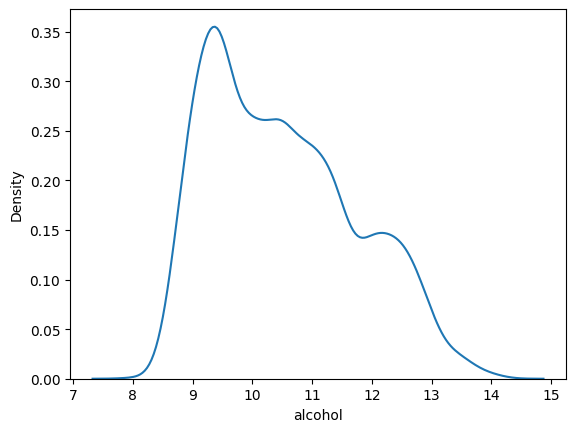

In [8]:
sns.kdeplot(data=data, x='alcohol')

<u>Density kernel density estimate plot</u>

<Axes: xlabel='density', ylabel='Density'>

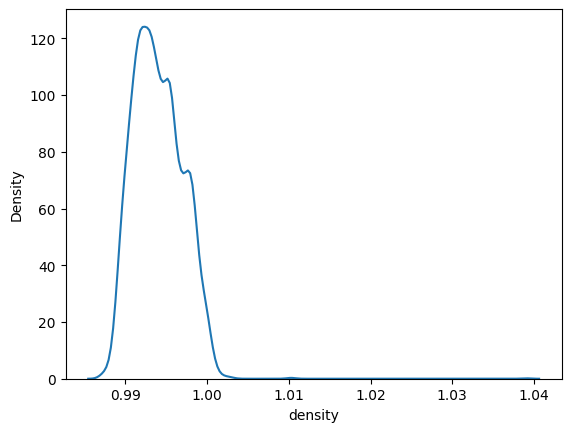

In [9]:
sns.kdeplot(data=data, x='density')

<u>Pair-Wise joint plot</u>

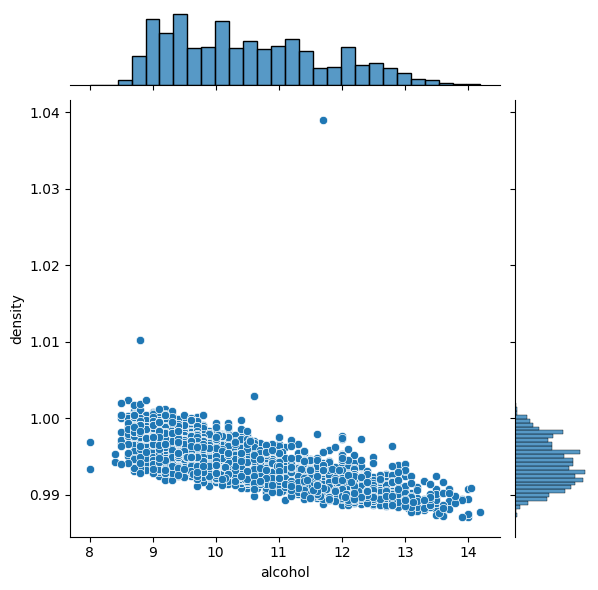

In [10]:
sns.jointplot(data=data, x="alcohol", y="density")

## Part B: Answers

The two distributions for the Kernel Density Estimate plots are roughly similar to each other <br>
but they are very much not normal distributions. They're more like a bumpy F distribution or perhaps <br>
a normal distribution skewed heavily to the left. As for the relations between the density <br>
and alcohol content shown in the pair-wise plot, we can clearly see that they are at least <br>
somewhat related. As the alcohol increases, the density seems to be going down. This makes <br>
sense because alcohol is less dense than water which means as the ratio between alcohol and <br>
water (or whatever other liquid is in as long as its more dense than alcohol) increases, <br>
the density of the liquid will decrease. 

<br>

## Part C: Pairwise Correlation and Heatmap

<Axes: >

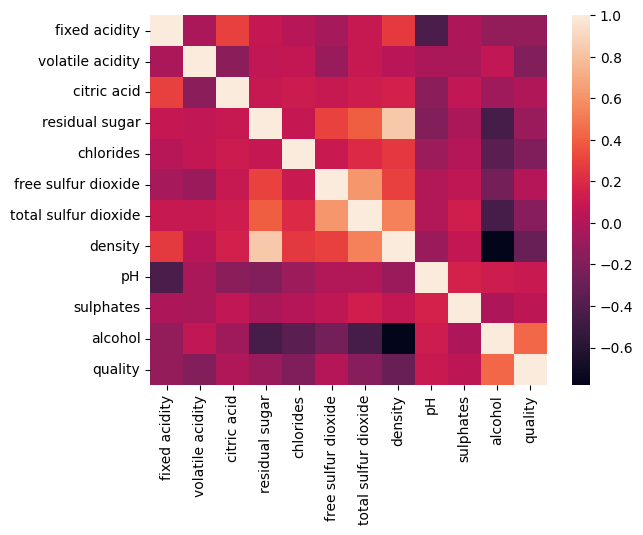

In [11]:
sns.heatmap(data.corr())

## Part C: Answers

One of the biggest correlations is between density and alcohol, which, as described <br>
in part B, makes complete sense. Outside of that, the relation between pH and fixed acidity <br>
is also quite highly negatively correlated which can be deduced, well, from the names. <br>
Residual sugar and alcohol are fairly negatively correlated as well as total sulfur dioxide <br>
and alcohol. Both of these make sense as there are quite a few alcohols that do not contain <br>
sulfides and alcohol likely contains less sugar than other things that might be with alcohol. <br>
As for positive correlations, sugar and density, free sulfur dioxide and total sulfur dioxide (duh), <br>
total sulfur dioxide and density, and alcohol and quality all tend to be fairly correlated. <br>
The last of which is pretty funny. 

<br>

---------------

# **Problem 2: Paramteric Modeling** 

## Part A: A Linear Model: Single Input

In [12]:
class MultiModel:
    def __init__(self, n_params=2, lr=0.01, epochs=500, print_rate=50):
        self.n_params = n_params
        self.lr = lr
        self.epochs = epochs
        self.print_rate = print_rate
        self.params = 0.1*torch.randn(n_params).float()
        self.params.requires_grad = True

    def forward(self, X):
        preds = torch.zeros(X.shape[0])
        for i in range(self.n_params-1):
            preds += self.params[i]*X[:,i]
        preds += self.params[-1]

        return preds

    # do gradient descent to tune params
    def train(self, X, y, criterion):
        for epoch in range(self.epochs):
            preds = self.forward(X)

            loss = criterion(preds, y)
            loss.backward()

            total_loss = loss.item()

            with torch.no_grad():
                self.params -= self.lr*self.params.grad
                self.params.grad.zero_() 

            if (epoch % self.print_rate == 0):
                print(f"[{epoch}] Loss: {total_loss}")

    def predict(self, X):
        return self.forward(X)
        

In [13]:
lm1 = MultiModel(
    lr=0.01,
    epochs=1000,
    print_rate=100
)

# also need to define the loss
# we can just use torch MSE

criterion = nn.MSELoss()

data.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6


I want to first extract the alcohol to test against the quality.

In [14]:
# normalized
X1 = X_tens[:,-2].detach().clone().view(X_tens.shape[0], 1)

# # this breaks
# # not normalized
# X = X_tens_not_normal[:, -1].detach().clone()

y1 = y_tens.detach().clone()

# test train split
# I didn't really want to make a dataloader

indices = np.random.permutation(X1.shape[0])
train_indices = indices[:int(X1.shape[0]*0.6)]
test_indices = indices[int(X1.shape[0]*0.6):]

train_X = X1[train_indices].detach().clone()
train_y = y1[train_indices].detach().clone()

test_X = X1[test_indices].detach().clone()
test_y1 = y1[test_indices].detach().clone()

lm1.train(train_X, train_y, criterion)

[0] Loss: 35.38643264770508
[100] Loss: 1.3818838596343994
[200] Loss: 0.784343957901001
[300] Loss: 0.7738373875617981
[400] Loss: 0.7736525535583496
[500] Loss: 0.7736492156982422
[600] Loss: 0.7736492156982422
[700] Loss: 0.7736492156982422
[800] Loss: 0.7736492156982422
[900] Loss: 0.7736492156982422


In [15]:
preds1 = lm1.predict(test_X)
print(preds1)

err = 0
for i,pred in enumerate(preds1):
    if (round(pred.item()) != test_y1[i].item()): err += 1

print(err / test_y1.shape[0])

tensor([5.8730, 5.9373, 5.8216,  ..., 5.8730, 5.9116, 6.0080],
       grad_fn=<AddBackward0>)
0.5423469387755102


## Part A: Answers

I chose the input to be the alcohol feature <br>
because that was the feature most strongly positively <br>
correlated on the heatmap with quality. I normalized the <br>
inputs by subtracting the mean and then dividing by the stddev <br>
because if I didn't it just kinda blew up. As for the equation used, <br>
it was as simple as y = mx + b where m and b are the parameters and x is in the input. <br>
y is the output. m and b were learned using gradient descent. <br>
As for a numerical analysis, the error rate of the prediction was found <br>
and the percent error was roughly 55.8%. This means that roughly 50% of the <br>
data points in the test set were predicted correctly. This isn't a great score, <br>
but using any of the other of the features gave worse scores so this is the one <br>
that I ended up sticking with. Violin plot is below. <br>

<Axes: >

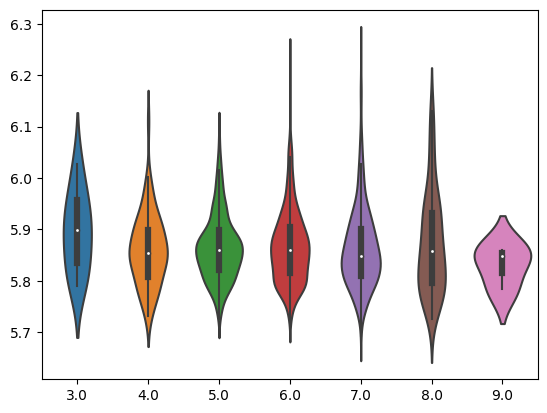

In [16]:
sns.violinplot(x=test_y1.detach().numpy(), y=preds1.detach().numpy())

<br>

## Part B: A Multiple-Linear Model: At Least 3 Inputs

In [17]:
# use 5 most strongly correlated attributes
lm2 = MultiModel(
    n_params=5,
    lr=0.01,
    epochs=1000,
    print_rate=100
)

# also need to define the loss
# we can just use torch MSE

criterion = nn.MSELoss()

data.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6


In [18]:
# normalized
X2 = X_tens[:,[3,5,6,9,10]].detach().clone()

# non-normalized
# X = X_tens_not_normal[:,[1,2,4,8,10]].detach().clone()

y2 = y_tens.detach().clone()

# test train split
# I didn't really want to make a dataloader

indices = np.random.permutation(X2.shape[0])
train_indices = indices[:int(X2.shape[0]*0.6)]
test_indices = indices[int(X2.shape[0]*0.6):]

train_X = X2[train_indices,:].detach().clone()
train_y = y2[train_indices].detach().clone()

test_X = X2[test_indices,:].detach().clone()
test_y2 = y2[test_indices].detach().clone()

lm2.train(train_X, train_y, criterion)

[0] Loss: 35.9221076965332
[100] Loss: 1.3787472248077393
[200] Loss: 0.7626118659973145
[300] Loss: 0.7496997117996216
[400] Loss: 0.7490097880363464
[500] Loss: 0.748891294002533
[600] Loss: 0.7488645315170288
[700] Loss: 0.7488582134246826
[800] Loss: 0.7488567233085632
[900] Loss: 0.7488564848899841


In [19]:
preds2 = lm2.predict(test_X)

print(lm2.params)

err = 0
for i,pred in enumerate(preds2):
    if (round(pred.item()) != test_y2[i].item()): err += 1

print(err / test_y2.shape[0])

tensor([-0.0497,  0.1794, -0.2275,  0.0666,  5.8870], requires_grad=True)
0.5591836734693878


## Part B: Answers

For the input features, I decided to try a few different things. <br>
Through my testing, I found that almost none of the features besides <br>
alcohol contributed to the final result. This would make sense because <br>
on the heatplot made in question one, none of the other features were <br>
really positively correlated with the quality besides alcohol content. <br>
All the data was normalized again because of exploding without it. <br>
The equation used to find the output was y = a1x1 + a2x2 + ... + anxn + b <br>
where a1..an and b were the parameters and x1..xn were the input feature columns. <br>
The result of this multi-linear model was pretty much the same as the linear model, <br>
which can be assumed when looking at how the other features besides alcohol <br>
content contibute to the final. Almost all of the features contributed close to zero, <br>
a lot even negatively, so the final percent error of 55% ended up pretty much the same <br>
as the linear model. The violin plot can be seen below. The thing to note about the <br>
violin plot is that, even though the error rate was relatively similar, the spread of <br>
the values was much higher than the linear model, showing that those other features <br>
were affecting it somewhat. 

<Axes: >

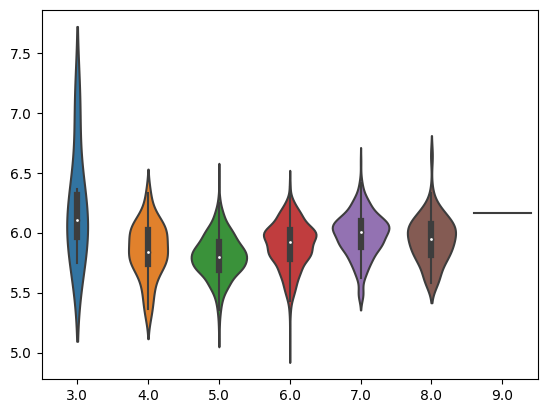

In [20]:
sns.violinplot(x=test_y2.detach().numpy(), y=preds2.detach().numpy())

<br>

## Part C: A Non-Linear Model: Variable Interaction / Nonlinear Terms

In [21]:
# use 3 features, one alcohol the rest combined
lm3 = MultiModel(
    n_params=3,
    lr=0.01,
    epochs=1000,
    print_rate=100
)

# also need to define the loss
# we can just use torch MSE

criterion = nn.MSELoss()

data.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6


In [22]:
# normalized
X3 = torch.zeros([X_tens.shape[0],3])

# just alcohol
X3[:,0] = X_tens[:,10]

# citric acid and residual sugar combined
X3[:,1] = X_tens[:,2]*X_tens[:,3]

# fixed acidity and total sulfur dioxide
X3[:,2] = X_tens[:,0]*X_tens[:,6]

y3 = y_tens.detach().clone()

# test train split
# I didn't really want to make a dataloader

indices = np.random.permutation(X3.shape[0])
train_indices = indices[:int(X3.shape[0]*0.6)]
test_indices = indices[int(X3.shape[0]*0.6):]

train_X = X3[train_indices,:].detach().clone()
train_y = y3[train_indices].detach().clone()

test_X = X3[test_indices,:].detach().clone()
test_y3 = y3[test_indices].detach().clone()

lm3.train(train_X, train_y, criterion)

[0] Loss: 33.95000076293945
[100] Loss: 1.2383131980895996
[200] Loss: 0.6395290493965149
[300] Loss: 0.6277438998222351
[400] Loss: 0.6275023221969604
[500] Loss: 0.6274972558021545
[600] Loss: 0.627497136592865
[700] Loss: 0.627497136592865
[800] Loss: 0.6274970769882202
[900] Loss: 0.6274970769882202


In [23]:
preds3 = lm3.predict(test_X)

print(lm3.params)

err = 0
for i,pred in enumerate(preds3):
    if (round(pred.item()) != test_y3[i].item()): err += 1

print(err / test_y3.shape[0])

preds_first = preds3.detach().numpy()

tensor([ 0.3841, -0.0240,  5.8667], requires_grad=True)
0.5081632653061224


Another one just for fun: Combine every unique pair and triplet of attributes

In [24]:
count = 0
for i in range(11):
    for j in range(i, 11):
        count += 1
        for k in range(j, 11):
            count += 1

print(count)

# use 3 features, one alcohol the rest combined
lm4 = MultiModel(
    n_params=count,
    lr=0.003,
    epochs=1000,
    print_rate=100
)

# also need to define the loss
# we can just use torch MSE

criterion = nn.MSELoss()

data.head()

352


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6


In [25]:
# normalized
X4 = torch.zeros([X_tens.shape[0],count+1])

# just alcohol
X4[:,0] = X_tens[:,10]

counter = 0
for i in range(11):
    for j in range(i, 11):
        X4[:,counter] = X_tens[:,i]*X_tens[:,j]
        counter += 1
        for k in range(j, 11):
            X4[:,counter] = X_tens[:,i]*X_tens[:,j]*X_tens[:,k]
            counter += 1


# re normalize data
X4 = (X4 - X4.mean()) / X4.std()

y4 = y_tens.detach().clone()

# test train split
# I didn't really want to make a dataloader

indices = np.random.permutation(X4.shape[0])
train_indices = indices[:int(X4.shape[0]*0.6)]
test_indices = indices[int(X4.shape[0]*0.6):]

train_X = X4[train_indices,:].detach().clone()
train_y = y4[train_indices].detach().clone()

test_X = X4[test_indices,:].detach().clone()
test_y4 = y4[test_indices].detach().clone()

lm4.train(train_X, train_y, criterion)

[0] Loss: 36.44135665893555
[100] Loss: 8.052019119262695
[200] Loss: 2.9351022243499756
[300] Loss: 1.6744986772537231
[400] Loss: 1.2590817213058472
[500] Loss: 1.0704962015151978
[600] Loss: 0.9607987403869629
[700] Loss: 0.886869490146637
[800] Loss: 0.8327687382698059
[900] Loss: 0.7911357879638672


In [26]:
preds4 = lm4.predict(test_X)

print(lm4.params)

err = 0
for i,pred in enumerate(preds4):
    print(round(pred.item()))
    if (round(pred.item()) != test_y4[i].item()): err += 1

print(err / test_y4.shape[0])

preds_triplets = preds4.detach().numpy()

tensor([ 4.0737e-01, -5.0272e-02, -1.1203e-01, -7.4945e-02, -7.1251e-02,
        -1.7502e-01,  1.5911e-01, -5.0814e-02, -1.4029e-01,  7.0569e-02,
        -7.8713e-02, -1.2101e-02, -4.1704e-02, -1.0174e-01, -1.8109e-01,
        -2.3479e-01,  3.8989e-02, -1.2158e-01, -1.5417e-01, -1.1730e-01,
        -2.4695e-01, -2.0335e-01,  1.2645e-01, -1.1723e-03, -1.2256e-02,
         1.3758e-01, -1.1805e-01, -1.9555e-01,  4.9002e-02,  4.9536e-02,
        -7.2880e-02, -6.4054e-02, -3.4865e-02, -8.6589e-02, -1.6734e-01,
        -1.9764e-02, -1.9837e-01, -7.6209e-02,  1.0356e-01, -1.0750e-01,
         5.0217e-03, -2.0691e-01,  1.0543e-01, -4.9974e-02, -9.0468e-03,
        -4.5582e-03, -1.4345e-01,  6.8109e-03, -5.5715e-02, -6.2622e-02,
        -7.1260e-02, -5.9753e-02, -1.3932e-01, -1.8567e-01,  8.3772e-03,
        -2.3819e-02, -3.4418e-01, -1.0273e-01, -4.5025e-02,  1.1612e-01,
        -1.4335e-01, -9.5804e-02, -1.4596e-01, -4.9315e-02,  3.6702e-02,
        -1.8212e-01, -5.8449e-03, -1.5948e-03, -2.7

None of this seems to be improving, lets see if any of these things matter at all

In [27]:
worth_param_count = 0
for param in lm4.params:
    if (param > 0.5):
        worth_param_count += 1

print(worth_param_count)

4


## Part C: Answers

For this, the first model that I tried, I selected those inputs <br>
that can be seen in the comments because they seemed like together <br>
they might affect how a drink was rated. Acidity combined with sulfur <br>
seems to me like it might lower the quality and perhaps sugar and citric acid <br>
may raise the quality? For the second model, I just combined every single unique <br>
pair and every single unique triplet and trained it on that. That proved to be <br>
fruitless, as the last above code shows, there are only 3 attributes that got even <br>
above 0.5 in the parameters, and the biggest of those is still just alcohol. <br>
I think showing the equations for these would be far too much writing but <br>
they follow the same pattern as part A and B. The inputs were normalized as <br>
the same in A and B due to explosion things. Both models, like the A and B models, <br>
got roughly 50% error rate, showing that combining attributes didn't really do much to <br>
improve the classification. Violin plots for both models of this part are below. <br>
A thing to note about these violin plots: the first plot for the only a couple combined <br>
attributes model is that it seems more spread out evenly than others, showing that maybe <br>
those combinations were affecting something. The second violin plot is messed up <br>
because of the sheer number of parameters likely. The gradient kept breaking when I was <br>
training it so its likely that it just kinda blew up.

<Axes: >

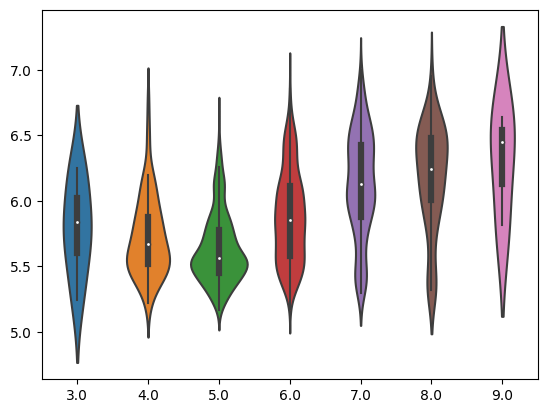

In [28]:
sns.violinplot(x=test_y3.detach().numpy(), y=preds_first)

<Axes: >

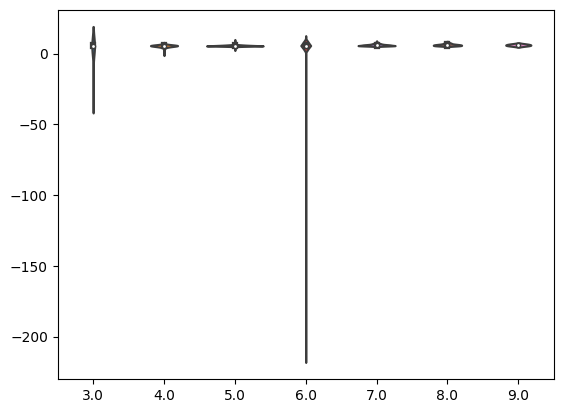

In [29]:
sns.violinplot(x=test_y4.detach().numpy(), y=preds_triplets)

<br>

---------------------------------------

# **Problem 3: Testing Accuracy**

In [30]:
def threshold_accuracy(preds, actual, T):
    # assume incoming are tensors
    predsnp = preds.detach().numpy()
    actualnp = actual.detach().numpy()

    diffs = np.abs(actualnp - predsnp)
    corrects = np.where(diffs <= T, 1, 0)
    return np.sum(corrects) / preds.shape[0]
    

In [31]:
print(
f'''
----- T = 0.25 -----
Threshold Accuracy Model 1: {threshold_accuracy(preds1, test_y1, 0.25)}
Thershold Accuracy Model 2: {threshold_accuracy(preds2, test_y2, 0.25)}
Thershold Accuracy Model 3: {threshold_accuracy(preds3, test_y3, 0.25)}
Thershold Accuracy Model 4: {threshold_accuracy(preds4, test_y4, 0.25)}
'''
)


----- T = 0.25 -----
Threshold Accuracy Model 1: 0.45051020408163267
Thershold Accuracy Model 2: 0.336734693877551
Thershold Accuracy Model 3: 0.22040816326530613
Thershold Accuracy Model 4: 0.1704081632653061



The model that performs the best when T = 0.25 is the first model with only the alcohol attribute. <br>
The difference in this one is quite significant, with 3 and 4 having 20% accuracy and 2 having 30%. 

In [32]:
print(
f'''
----- T = 0.5 -----
Threshold Accuracy Model 1: {threshold_accuracy(preds1, test_y1, 0.5)}
Thershold Accuracy Model 2: {threshold_accuracy(preds2, test_y2, 0.5)}
Thershold Accuracy Model 3: {threshold_accuracy(preds3, test_y3, 0.5)}
Thershold Accuracy Model 4: {threshold_accuracy(preds4, test_y4, 0.5)}
'''
)


----- T = 0.5 -----
Threshold Accuracy Model 1: 0.4576530612244898
Thershold Accuracy Model 2: 0.44081632653061226
Thershold Accuracy Model 3: 0.49183673469387756
Thershold Accuracy Model 4: 0.41785714285714287



The model that performs best when T = 0.5 is model 3 with alcohol and the two combined attributes. <br>
The difference with this one, however, is not very significant, and model 1 has the same accuracy as with T = 0.25.

In [33]:
print(
f'''
----- T = 1.0 -----
Threshold Accuracy Model 1: {threshold_accuracy(preds1, test_y1, 1.0)}
Thershold Accuracy Model 2: {threshold_accuracy(preds2, test_y2, 1.0)}
Thershold Accuracy Model 3: {threshold_accuracy(preds3, test_y3, 1.0)}
Thershold Accuracy Model 4: {threshold_accuracy(preds4, test_y4, 1.0)}
'''
)


----- T = 1.0 -----
Threshold Accuracy Model 1: 0.7397959183673469
Thershold Accuracy Model 2: 0.8
Thershold Accuracy Model 3: 0.825
Thershold Accuracy Model 4: 0.7612244897959184



The model that performs best when T = 1.0 is model 3 again. <br>
Like the previous T, the difference is not too signiciant, however, <br>
this time, model 4 is more on level with the others. 

<br>

-----------------------------------------------

# **Problem 4: Cross Validation**

In [34]:
X_sets = [X1, X2, X3]
y_sets = [y1, y2, y3]

models = [
    {
        "n_params": 2,
        "lr": 0.01,
        "epochs": 1000,
        "print_rate": 100
    },

    {
        "n_params": 5,
        "lr": 0.01,
        "epochs": 1000,
        "print_rate": 100
    },

    {
        "n_params": 3,
        "lr": 0.01,
        "epochs": 1000,
        "print_rate": 100
    },
]

criterion = nn.MSELoss()

In [35]:
def kfold_validation(X, y, model, criterion, folds=10):
    predictions = []
    accuracy1 = np.zeros(folds)
    accuracy2 = np.zeros(folds)
    accuracy3 = np.zeros(folds)

    inds = np.arange(X.shape[0])
    scale = int(X.shape[0]*(1/folds))

    for k in range(folds):
        m = MultiModel(
            n_params=model["n_params"],
            lr=model["lr"],
            epochs=model["epochs"],
            print_rate=model["print_rate"]
        )

        print(scale)

        train_indices = inds[:k*scale]
        train_indices = np.append(train_indices, inds[(k+1)*scale:])
        valid_indices = inds[k*scale:(k+1)*scale]

        X_train = X[train_indices].detach().clone()
        y_train = y[train_indices].detach().clone()

        X_valid = X[valid_indices].detach().clone()
        y_valid = y[valid_indices].detach().clone()

        m.train(X_train, y_train, criterion)
        preds = m.predict(X_valid)

        accuracy1[k] = threshold_accuracy(preds, y_valid, 0.25)
        accuracy2[k] = threshold_accuracy(preds, y_valid, 0.50)
        accuracy3[k] = threshold_accuracy(preds, y_valid, 1.00)
    
    return np.array([accuracy1, accuracy2, accuracy3])
    

In [36]:
model_accuracies = []
for i in range(3):
    model_accuracies.append(kfold_validation(X_sets[i], y_sets[i], models[i], criterion, 10))

489
[0] Loss: 36.9130973815918
[100] Loss: 1.4163743257522583
[200] Loss: 0.792306125164032
[300] Loss: 0.7813308238983154
[400] Loss: 0.7811377644538879
[500] Loss: 0.781134307384491
[600] Loss: 0.7811342477798462
[700] Loss: 0.781134307384491
[800] Loss: 0.781134307384491
[900] Loss: 0.781134307384491
489
[0] Loss: 35.51712417602539
[100] Loss: 1.3762301206588745
[200] Loss: 0.7754369974136353
[300] Loss: 0.7648242712020874
[400] Loss: 0.7646361589431763
[500] Loss: 0.7646327018737793
[600] Loss: 0.7646325826644897
[700] Loss: 0.7646325826644897
[800] Loss: 0.7646326422691345
[900] Loss: 0.7646326422691345
489
[0] Loss: 36.42066955566406
[100] Loss: 1.392714500427246
[200] Loss: 0.7773378491401672
[300] Loss: 0.7665072083473206
[400] Loss: 0.7663161754608154
[500] Loss: 0.766312837600708
[600] Loss: 0.766312837600708
[700] Loss: 0.766312837600708
[800] Loss: 0.7663127183914185
[900] Loss: 0.7663127183914185
489
[0] Loss: 34.567840576171875
[100] Loss: 1.3793678283691406
[200] Loss: 0

In [37]:
print(model_accuracies)

[array([[0.43353783, 0.39263804, 0.42126789, 0.46216769, 0.39672802,
        0.39877301, 0.47648262, 0.44580777, 0.48466258, 0.56646217],
       [0.43353783, 0.39263804, 0.42126789, 0.46216769, 0.39672802,
        0.39877301, 0.48261759, 0.44580777, 0.48466258, 0.56646217],
       [0.76891616, 0.70347648, 0.69734151, 0.77300613, 0.80368098,
        0.73210634, 0.68507157, 0.70961145, 0.78936605, 0.81390593]]), array([[0.27811861, 0.2392638 , 0.29856851, 0.28834356, 0.31083845,
        0.28629857, 0.38241309, 0.32719836, 0.41308793, 0.4601227 ],
       [0.4192229 , 0.38241309, 0.43558282, 0.45807771, 0.40695297,
        0.400818  , 0.47443763, 0.44376278, 0.49079755, 0.55010225],
       [0.76687117, 0.74437628, 0.69529652, 0.77505112, 0.80572597,
        0.79754601, 0.75255624, 0.76891616, 0.81595092, 0.8609407 ]]), array([[0.14110429, 0.16155419, 0.21267894, 0.21267894, 0.17586912,
        0.21472393, 0.21472393, 0.22903885, 0.24948875, 0.25153374],
       [0.47852761, 0.45603272, 0.42

In [38]:

print(
f''' 
------------- T = 0.25 -------------
Model [{1}]:
    Mean Accuracy: {np.mean(model_accuracies[0][0])}
    Std Accuracy: {np.std(model_accuracies[0][0])}

Model [{2}]:
    Mean Accuracy: {np.mean(model_accuracies[1][0])}
    Std Accuracy: {np.std(model_accuracies[1][0])}

Model [{3}]:
    Mean Accuracy: {np.mean(model_accuracies[2][0])}
    Std Accuracy: {np.std(model_accuracies[2][0])}
'''
)

 
------------- T = 0.25 -------------
Model [1]:
    Mean Accuracy: 0.4478527607361963
    Std Accuracy: 0.05043294726778034

Model [2]:
    Mean Accuracy: 0.32842535787321064
    Std Accuracy: 0.06518483098292017

Model [3]:
    Mean Accuracy: 0.20633946830265848
    Std Accuracy: 0.034395366283966305



Once again, model 1 performs best of the three in average accuracy. <br>
As for standard deviation of the accuracies, model 3 does the best with model 1 coming second. <br>
Once again, the accuracy differences are statistically significant, however, the stddevs are quite <br>
small so perhaps overall they are not statistically significant. Though, when considering the <br>
magnitude they are at, they are quite different from each other.

In [39]:
print(
f''' 
------------- T = 0.50 -------------
Model [{1}]:
    Mean Accuracy: {np.mean(model_accuracies[0][1])}
    Std Accuracy: {np.std(model_accuracies[0][1])}

Model [{2}]:
    Mean Accuracy: {np.mean(model_accuracies[1][1])}
    Std Accuracy: {np.std(model_accuracies[1][1])}

Model [{3}]:
    Mean Accuracy: {np.mean(model_accuracies[2][1])}
    Std Accuracy: {np.std(model_accuracies[2][1])}
'''
)

 
------------- T = 0.50 -------------
Model [1]:
    Mean Accuracy: 0.4484662576687116
    Std Accuracy: 0.050813366698174

Model [2]:
    Mean Accuracy: 0.44621676891615536
    Std Accuracy: 0.04715730458614706

Model [3]:
    Mean Accuracy: 0.478118609406953
    Std Accuracy: 0.02085087459555155



Model 3 performed best again for average accuracy, but not by a meaninful margin. <br>
1 and 2 were close with standard deviation but model 3 really went low in this category. <br>
Accuracy differences are not really statistically significant, however, I think model 3 <br>
having a relatively lower stddev might be. 

In [40]:
print(
f''' 
------------- T = 1.00 -------------
Model [{1}]:
    Mean Accuracy: {np.mean(model_accuracies[0][2])}
    Std Accuracy: {np.std(model_accuracies[0][2])}

Model [{2}]:
    Mean Accuracy: {np.mean(model_accuracies[1][2])}
    Std Accuracy: {np.std(model_accuracies[1][2])}

Model [{3}]:
    Mean Accuracy: {np.mean(model_accuracies[2][2])}
    Std Accuracy: {np.std(model_accuracies[2][2])}
'''
)

 
------------- T = 1.00 -------------
Model [1]:
    Mean Accuracy: 0.7476482617586913
    Std Accuracy: 0.04522341267947752

Model [2]:
    Mean Accuracy: 0.7783231083844582
    Std Accuracy: 0.04278087328378251

Model [3]:
    Mean Accuracy: 0.832924335378323
    Std Accuracy: 0.03834614851510095



All do pretty much the same in both metrics with model 3 being slightly ahead in <br>
both metrics, though, the differences are not statistically significant, even relatively. 

<br>

-----------------------------------------------

# **Extra Credit: SKlearn KNN Regressor**

In [41]:
from sklearn.neighbors import KNeighborsRegressor 

In [59]:
def threshold_accuracy_not_torch(preds, actual, T):
    diffs = np.abs(actual - preds)
    corrects = np.where(diffs <= T, 1, 0)
    return np.sum(corrects) / preds.shape[0]
    

def kfold_validation_not_torch(X, y, folds=10, neigbs=1):
    predictions = []
    accuracy3 = np.zeros(folds)

    inds = np.arange(X.shape[0])
    scale = int(X.shape[0]*(1/folds))

    for k in range(folds):
        train_indices = inds[:k*scale]
        train_indices = np.append(train_indices, inds[(k+1)*scale:])
        valid_indices = inds[k*scale:(k+1)*scale]

        X_train = X[train_indices]
        y_train = y[train_indices]

        X_valid = X[valid_indices]
        y_valid = y[valid_indices]

        model = KNeighborsRegressor(
            n_neighbors=neigbs,
            weights="distance",
        )

        model.fit(X_train, y_train)
        preds = model.predict(X_valid)

        accuracy3[k] = threshold_accuracy_not_torch(preds, y_valid, 1.00)
    
    return accuracy3

<Axes: >

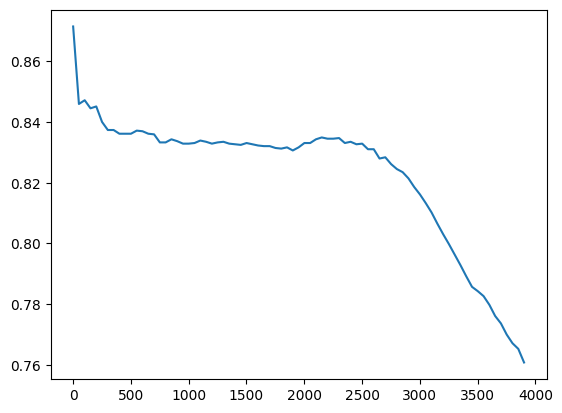

In [60]:
averages = []
neighbors = []
for i in range(1, int(X_np.shape[0]*(4/5)), 50):
    averages.append(np.mean(kfold_validation_not_torch(X_np, y_np, 5, i)))
    neighbors.append(i)

sns.lineplot(x=neighbors, y=averages)

In [61]:
max_ind = np.argmax(averages)
print(max_ind)

0


In [62]:
print(np.mean(kfold_validation_not_torch(X_np, y_np, 5, neighbors[max_ind])))

0.8715015321756894


The threshold gotten by a KNneighbors Regressor was 87%. <br>
The number of neighbors used for this was 1 and that number was obtained <br>
through just trying a bunch of numbers as can be seen above. <br>
This roughly half a percent higher than the results gotten by a SVM <br>
while being significantly faster and simpler. **KNN really can do everything.**